# Notebook 5: Identify Route Parish Intersections

## Introduction to Noteboook 5

Why are route-parish intersections important? https://cw.fel.cvut.cz/b181/_media/courses/cg/lectures/09-intersect.pdf



In [1]:
import osmnx as ox, csv

with open('overpass-api.csv', mode='r') as infile:
    reader = csv.reader(infile)
    overpass_api = {rows[0]:rows[1] for rows in reader}

ox.config(
    log_console=False, 
    use_cache=True, 
    log_file=True,
    overpass_endpoint=overpass_api['main']
)

In [2]:
%%time
if 'G_proj' not in globals():
    G_proj = ox.load_graphml('data/g_projected.graphml')

if 'G' not in globals():
    G = ox.load_graphml('data/g_unprojected.graphml')

CPU times: user 37.8 s, sys: 1.19 s, total: 39 s
Wall time: 39.1 s


## Data sources

In [3]:
import pandas as pd, geopandas as gpd, folium

pd.options.display.float_format = '{:.10f}'.format

### Paired cache GDF, parishes GDF

In [4]:
parishes_gdf = gpd.read_file('data/parishes_gdf.gpkg')
paired_cache_df = pd.read_pickle('data/paired_cache_df.pickle')

In [5]:
parishes_gdf

,GID_0,NAME_0,GID_1,NAME_1,GID_2,NAME_2,GID_3,NAME_3,GID_4,NAME_4,VARNAME_4,TYPE_4,ENGTYPE_4,CC_4,area_sqm,centroid_x,centroid_y,geometry
0,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.1_1,Central Division,UGA.16.1.1.1_1,Bukesa,None,Parish,Parish,None,559768.3975113713,451524.4166484834,35906.9724917396,"MULTIPOLYGON (((32.56321 0.31958, 32.56292 0.3..."
1,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.1_1,Central Division,UGA.16.1.1.2_1,Civic Centre,None,Parish,Parish,None,1209455.8146584462,453884.4876301024,34880.4453069278,"MULTIPOLYGON (((32.57724 0.30992, 32.57730 0.3..."
2,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.1_1,Central Division,UGA.16.1.1.3_1,Industrial Area,None,Parish,Parish,None,1776410.1888784864,455890.3457818956,35463.5391795589,"MULTIPOLYGON (((32.60664 0.31585, 32.60598 0.3..."
3,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.1_1,Central Division,UGA.16.1.1.4_1,Kagugube,None,Parish,Parish,None,502708.6719317246,452030.8561209833,36273.6179740557,"MULTIPOLYGON (((32.57084 0.32427, 32.57058 0.3..."
4,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.1_1,Central Division,UGA.16.1.1.5_1,Kamwokya I,None,Parish,Parish,None,411428.6768850113,454564.2625147337,38168.9266840896,"MULTIPOLYGON (((32.58500 0.34132, 32.58651 0.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.5_1,Rubaga Division,UGA.16.1.5.9_1,Nakulabye,None,Parish,Parish,None,1026084.8535207562,450559.2039879204,36410.2678852486,"MULTIPOLYGON (((32.54860 0.33223, 32.55151 0.3..."
92,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.5_1,Rubaga Division,UGA.16.1.5.10_1,Namirembe,None,Parish,Parish,None,1859599.6021243404,450911.3264704964,35032.9390910053,"MULTIPOLYGON (((32.56114 0.30923, 32.56108 0.3..."
93,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.5_1,Rubaga Division,UGA.16.1.5.11_1,Nateete,None,Parish,Parish,None,1804795.3528157366,448176.4503960741,33820.1469633023,"MULTIPOLYGON (((32.54007 0.30528, 32.53991 0.3..."
94,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.5_1,Rubaga Division,UGA.16.1.5.12_1,Ndeeba,None,Parish,Parish,None,1962463.6518844874,451649.7161646702,33182.2916360861,"MULTIPOLYGON (((32.57188 0.29548, 32.57166 0.2..."


## Create GDF from paired cache DF

In [6]:
import yaml

with open("proj_crs.yml", "r") as stream:
    try:
        epsg_dict = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
        
proj_epsg_str = str(epsg_dict).replace("{","").replace("}", "").replace("'","").replace(" ","")

print('Projected graph EPSG code:',proj_epsg_str)

Projected graph EPSG code: EPSG:32636


In [7]:
paired_cache_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   r_node          74 non-null     int64  
 1   parish_name     74 non-null     object 
 2   r_node_lat      74 non-null     float64
 3   r_node_lon      74 non-null     float64
 4   t_node          74 non-null     int64  
 5   t_node_lat      74 non-null     float64
 6   t_node_lon      74 non-null     float64
 7   d3_euc          45 non-null     float64
 8   d3_shapely      45 non-null     object 
 9   path_node_list  74 non-null     object 
 10  path_distances  35 non-null     object 
 11  d3_path_sum     45 non-null     float64
 12  d3_edge_attrs   45 non-null     float64
 13  d_total         74 non-null     float64
 14  d1              39 non-null     float64
 15  d2              39 non-null     float64
 16  d3              29 non-null     float64
 17  prj_lat         10 non-null     float

In [8]:
%%time
from oxtools.compute_d3 import nodes_to_linestring

paired_cache_df['geometry'] = paired_cache_df['path_node_list'].map(\
            lambda x: nodes_to_linestring(x, G_proj))

CPU times: user 21.1 ms, sys: 43 µs, total: 21.2 ms
Wall time: 19.9 ms


In [9]:
paired_cache_gdf = gpd.GeoDataFrame(paired_cache_df, geometry='geometry', crs=proj_epsg_str)

paired_cache_gdf

,r_node,parish_name,r_node_lat,r_node_lon,t_node,t_node_lat,t_node_lon,d3_euc,d3_shapely,path_node_list,...,d3_edge_attrs,d_total,d1,d2,d3,prj_lat,prj_lon,PRJ_LAT,PRJ_LON,geometry
0,6224792359,Kabowa,0.2873915000,32.5623252000,5572008964,0.2883498000,32.5594612000,246.4599184290,764.8577704742,"[6224792359, 557330540, 557330539, 557330554, ...",...,766.7720000000,863.0244679421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (451297.885 31766.331, 451300.567 3..."
1,6241486007,Kabowa,0.2910965000,32.5589864000,5572008964,0.2883498000,32.5594612000,306.8949496724,489.8071930412,"[6241486007, 6241486005, 6100868024, 493323985...",...,491.3860000000,540.4074311963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (450926.369 32175.872, 450924.132 3..."
2,2085397292,Kabowa,0.2852278000,32.5606116000,5572008964,0.2883498000,32.5594612000,367.1917534631,571.3800720441,"[2085397292, 2085397298, 2085397289, 208539729...",...,573.4790000000,641.7737756892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (451107.191 31527.178, 451085.692 3..."
3,7100592251,Kabowa,0.2925402000,32.5509825000,5572008964,0.2883498000,32.5594612000,1079.1479627214,1401.1835808965,"[7100592251, 7100592252, 7100592253, 710059225...",...,1402.8320000000,1443.0140758016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (450035.726 32335.484, 450039.866 3..."
4,6229407820,Kabowa,0.2911225000,32.5589936000,5572008964,0.2883498000,32.5594612000,304.2698779717,492.7906517788,"[6229407820, 6241486007, 6241486005, 610086802...",...,494.3860000000,552.0968891205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (450927.171 32178.746, 450926.369 3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,6213151721,Mutundwe,0.2781923000,32.5400341000,5572008964,0.2883498000,32.5594612000,2450.7139278784,LINESTRING (448817.3573167607 30749.6076976613...,"[6213151721, 6213151722, 6213151723, 809625964...",...,3217.5380000000,3264.0994538768,15.6487307896,30.9127230872,NaN,30763.4974547303,448824.5654665851,31872.2887513557,451010.1044428619,"LINESTRING (448817.357 30749.608, 448820.640 3..."
70,6225392068,Mutundwe,0.2800148000,32.5444677000,5572008964,0.2883498000,32.5594612000,1961.4108512061,LINESTRING (449310.72386884096 30951.036026065...,"[6225392068, 6225392069, 6225392070, 557315093...",...,2550.2530000000,2610.0477837897,28.8820607025,30.9127230872,NaN,30942.2524388433,449283.2098355863,31872.2887513557,451010.1044428619,"LINESTRING (449310.724 30951.036, 449311.626 3..."
71,6225526253,Mutundwe,0.2871910000,32.5451966000,5572008964,0.2883498000,32.5594612000,1617.1432260912,LINESTRING (449391.8649700851 31744.2439457506...,"[6225526253, 6226887750, 1242682715, 557345641...",...,2082.1630000000,2121.1048580231,8.0291349359,30.9127230872,NaN,31749.8610510506,449397.6021415021,31872.2887513557,451010.1044428619,"LINESTRING (449391.865 31744.244, 449396.494 3..."
72,7103214804,Mutundwe,0.2860457000,32.5470935000,5572008964,0.2883498000,32.5594612000,1426.4104372214,LINESTRING (449602.9414741557 31617.6414895286...,"[7103214804, 7105675803, 7105675698, 557314191...",...,1864.6760000000,1900.2629805301,4.6742574429,30.9127230872,NaN,31615.3640677507,449607.0233894767,31872.2887513557,451010.1044428619,"LINESTRING (449602.941 31617.641, 449621.136 3..."


### Change GDF projection

In [10]:
paired_cache_proj_gdf = paired_cache_gdf.to_crs(proj_epsg_str)
parishes_proj_gdf = parishes_gdf.to_crs(proj_epsg_str)

### Add two new columns

In [11]:
paired_cache_proj_gdf['parish_route'] = ''
paired_cache_proj_gdf['parish_num'] = 0

In [12]:
paired_cache_proj_gdf

,r_node,parish_name,r_node_lat,r_node_lon,t_node,t_node_lat,t_node_lon,d3_euc,d3_shapely,path_node_list,...,d1,d2,d3,prj_lat,prj_lon,PRJ_LAT,PRJ_LON,geometry,parish_route,parish_num
0,6224792359,Kabowa,0.2873915000,32.5623252000,5572008964,0.2883498000,32.5594612000,246.4599184290,764.8577704742,"[6224792359, 557330540, 557330539, 557330554, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (451297.885 31766.331, 451300.567 3...",,0
1,6241486007,Kabowa,0.2910965000,32.5589864000,5572008964,0.2883498000,32.5594612000,306.8949496724,489.8071930412,"[6241486007, 6241486005, 6100868024, 493323985...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (450926.369 32175.872, 450924.132 3...",,0
2,2085397292,Kabowa,0.2852278000,32.5606116000,5572008964,0.2883498000,32.5594612000,367.1917534631,571.3800720441,"[2085397292, 2085397298, 2085397289, 208539729...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (451107.191 31527.178, 451085.692 3...",,0
3,7100592251,Kabowa,0.2925402000,32.5509825000,5572008964,0.2883498000,32.5594612000,1079.1479627214,1401.1835808965,"[7100592251, 7100592252, 7100592253, 710059225...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (450035.726 32335.484, 450039.866 3...",,0
4,6229407820,Kabowa,0.2911225000,32.5589936000,5572008964,0.2883498000,32.5594612000,304.2698779717,492.7906517788,"[6229407820, 6241486007, 6241486005, 610086802...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (450927.171 32178.746, 450926.369 3...",,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,6213151721,Mutundwe,0.2781923000,32.5400341000,5572008964,0.2883498000,32.5594612000,2450.7139278784,LINESTRING (448817.3573167607 30749.6076976613...,"[6213151721, 6213151722, 6213151723, 809625964...",...,15.6487307896,30.9127230872,NaN,30763.4974547303,448824.5654665851,31872.2887513557,451010.1044428619,"LINESTRING (448817.357 30749.608, 448820.640 3...",,0
70,6225392068,Mutundwe,0.2800148000,32.5444677000,5572008964,0.2883498000,32.5594612000,1961.4108512061,LINESTRING (449310.72386884096 30951.036026065...,"[6225392068, 6225392069, 6225392070, 557315093...",...,28.8820607025,30.9127230872,NaN,30942.2524388433,449283.2098355863,31872.2887513557,451010.1044428619,"LINESTRING (449310.724 30951.036, 449311.626 3...",,0
71,6225526253,Mutundwe,0.2871910000,32.5451966000,5572008964,0.2883498000,32.5594612000,1617.1432260912,LINESTRING (449391.8649700851 31744.2439457506...,"[6225526253, 6226887750, 1242682715, 557345641...",...,8.0291349359,30.9127230872,NaN,31749.8610510506,449397.6021415021,31872.2887513557,451010.1044428619,"LINESTRING (449391.865 31744.244, 449396.494 3...",,0
72,7103214804,Mutundwe,0.2860457000,32.5470935000,5572008964,0.2883498000,32.5594612000,1426.4104372214,LINESTRING (449602.9414741557 31617.6414895286...,"[7103214804, 7105675803, 7105675698, 557314191...",...,4.6742574429,30.9127230872,NaN,31615.3640677507,449607.0233894767,31872.2887513557,451010.1044428619,"LINESTRING (449602.941 31617.641, 449621.136 3...",,0


References:
1. Convex Hull: https://geopandas.org/docs/user_guide/geometric_manipulations.html#GeoSeries.convex_hull
2. Distance between geoseries: https://geopandas.org/docs/reference/api/geopandas.GeoSeries.distance.html#geopandas.GeoSeries.distance
3. Geoseries contains: https://geopandas.org/docs/reference/api/geopandas.GeoSeries.contains.html#

## Set Parish GDF index to `NAME_4` (parish name)

In [13]:
parishes_proj_gdf = parishes_proj_gdf.set_index(['NAME_4'])

In [14]:
parishes_proj_gdf.loc[['Kisugu']]

,GID_0,NAME_0,GID_1,NAME_1,GID_2,NAME_2,GID_3,NAME_3,GID_4,VARNAME_4,TYPE_4,ENGTYPE_4,CC_4,area_sqm,centroid_x,centroid_y,geometry
NAME_4,,,,,,,,,,,,,,,,,
Kisugu,UGA,Uganda,UGA.16_1,Kampala,UGA.16.1_1,Kampala,UGA.16.1.3_1,Makindye,UGA.16.1.3.11_1,None,Parish,Parish,None,1227491.9265254750,456230.4708387037,34104.6820534491,"MULTIPOLYGON (((456229.976 33480.017, 456139.1..."


## Identify route-parish intersections and parish routes

In [15]:
parishes = [ row.Index for row in parishes_proj_gdf.itertuples() ]

In [16]:
paired_cache_proj_gdf

,r_node,parish_name,r_node_lat,r_node_lon,t_node,t_node_lat,t_node_lon,d3_euc,d3_shapely,path_node_list,...,d1,d2,d3,prj_lat,prj_lon,PRJ_LAT,PRJ_LON,geometry,parish_route,parish_num
0,6224792359,Kabowa,0.2873915000,32.5623252000,5572008964,0.2883498000,32.5594612000,246.4599184290,764.8577704742,"[6224792359, 557330540, 557330539, 557330554, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (451297.885 31766.331, 451300.567 3...",,0
1,6241486007,Kabowa,0.2910965000,32.5589864000,5572008964,0.2883498000,32.5594612000,306.8949496724,489.8071930412,"[6241486007, 6241486005, 6100868024, 493323985...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (450926.369 32175.872, 450924.132 3...",,0
2,2085397292,Kabowa,0.2852278000,32.5606116000,5572008964,0.2883498000,32.5594612000,367.1917534631,571.3800720441,"[2085397292, 2085397298, 2085397289, 208539729...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (451107.191 31527.178, 451085.692 3...",,0
3,7100592251,Kabowa,0.2925402000,32.5509825000,5572008964,0.2883498000,32.5594612000,1079.1479627214,1401.1835808965,"[7100592251, 7100592252, 7100592253, 710059225...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (450035.726 32335.484, 450039.866 3...",,0
4,6229407820,Kabowa,0.2911225000,32.5589936000,5572008964,0.2883498000,32.5594612000,304.2698779717,492.7906517788,"[6229407820, 6241486007, 6241486005, 610086802...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (450927.171 32178.746, 450926.369 3...",,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,6213151721,Mutundwe,0.2781923000,32.5400341000,5572008964,0.2883498000,32.5594612000,2450.7139278784,LINESTRING (448817.3573167607 30749.6076976613...,"[6213151721, 6213151722, 6213151723, 809625964...",...,15.6487307896,30.9127230872,NaN,30763.4974547303,448824.5654665851,31872.2887513557,451010.1044428619,"LINESTRING (448817.357 30749.608, 448820.640 3...",,0
70,6225392068,Mutundwe,0.2800148000,32.5444677000,5572008964,0.2883498000,32.5594612000,1961.4108512061,LINESTRING (449310.72386884096 30951.036026065...,"[6225392068, 6225392069, 6225392070, 557315093...",...,28.8820607025,30.9127230872,NaN,30942.2524388433,449283.2098355863,31872.2887513557,451010.1044428619,"LINESTRING (449310.724 30951.036, 449311.626 3...",,0
71,6225526253,Mutundwe,0.2871910000,32.5451966000,5572008964,0.2883498000,32.5594612000,1617.1432260912,LINESTRING (449391.8649700851 31744.2439457506...,"[6225526253, 6226887750, 1242682715, 557345641...",...,8.0291349359,30.9127230872,NaN,31749.8610510506,449397.6021415021,31872.2887513557,451010.1044428619,"LINESTRING (449391.865 31744.244, 449396.494 3...",,0
72,7103214804,Mutundwe,0.2860457000,32.5470935000,5572008964,0.2883498000,32.5594612000,1426.4104372214,LINESTRING (449602.9414741557 31617.6414895286...,"[7103214804, 7105675803, 7105675698, 557314191...",...,4.6742574429,30.9127230872,NaN,31615.3640677507,449607.0233894767,31872.2887513557,451010.1044428619,"LINESTRING (449602.941 31617.641, 449621.136 3...",,0


In [18]:
%%time
from shapely.geometry import Point
from tqdm import tqdm, notebook
from oxtools.compute_d3 import get_parish_route
# tqdm parameters
total_rows=paired_cache_proj_gdf.shape[0]

# route loop
for r_row in tqdm(paired_cache_proj_gdf.itertuples(), total=total_rows):

    # parishes intersected by route
    parish_list = [ p_row.Index for p_row in parishes_proj_gdf.itertuples() if r_row.geometry.distance(p_row.geometry.convex_hull) == 0 ]
    # go through path nodes to get right order of parishes (parish_route)
    parish_route = get_parish_route(r_row.path_node_list, parishes_proj_gdf, parish_list, G_proj)
    paired_cache_proj_gdf.at[r_row.Index, 'parish_route'] = parish_route
    paired_cache_proj_gdf.at[r_row.Index, 'parish_num'] = len(parish_route)
    

100%|██████████| 74/74 [00:37<00:00,  1.98it/s]

CPU times: user 37.4 s, sys: 31.6 ms, total: 37.4 s
Wall time: 37.4 s


<AxesSubplot:title={'center':'Sample Residence-to-Test-Facility Routes through Parishes in Kampala'}>

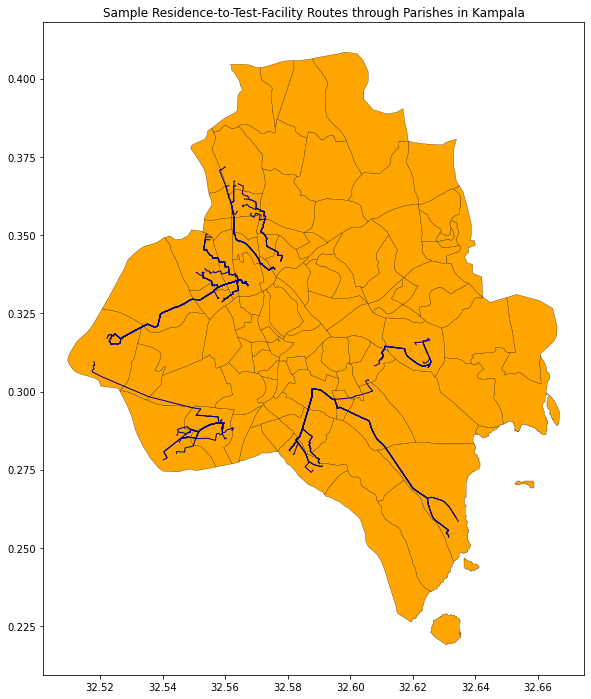

In [21]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(24, 12))
plt.title('Sample Residence-to-Test-Facility Routes through Parishes in Kampala')
parishes_gdf.plot(ax=ax1, color='orange', edgecolor='black', linewidth=0.25)
paired_cache_proj_gdf.to_crs('EPSG:4326').plot(ax=ax1, color='darkblue', linewidth=1)

In [28]:
paired_cache_proj_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   r_node          74 non-null     int64   
 1   parish_name     74 non-null     object  
 2   r_node_lat      74 non-null     float64 
 3   r_node_lon      74 non-null     float64 
 4   t_node          74 non-null     int64   
 5   t_node_lat      74 non-null     float64 
 6   t_node_lon      74 non-null     float64 
 7   d3_euc          45 non-null     float64 
 8   d3_shapely      45 non-null     object  
 9   path_node_list  74 non-null     object  
 10  path_distances  35 non-null     object  
 11  d3_path_sum     45 non-null     float64 
 12  d3_edge_attrs   45 non-null     float64 
 13  d_total         74 non-null     float64 
 14  d1              39 non-null     float64 
 15  d2              39 non-null     float64 
 16  d3              29 non-null     float64 
 17  prj_lat   

In [30]:
paired_cache_proj_gdf[['parish_name', 'parish_num', 'd3_edge_attrs']].groupby(['parish_name']).mean()

,parish_num,d3_edge_attrs
parish_name,,
Bogolobi,1.0000000000,1166.4496000000
Busega,6.8000000000,NaN
Bwaise I,5.2000000000,3298.4214000000
Ggaba,4.0000000000,7469.9092000000
Kabowa,1.4000000000,745.7710000000
Kasubi,3.6666666667,NaN
Kawempe I,6.6000000000,4216.7260000000
Kisugu,3.4000000000,2770.8210000000
Luwafu,3.2000000000,NaN


<AxesSubplot:xlabel='parish_name'>

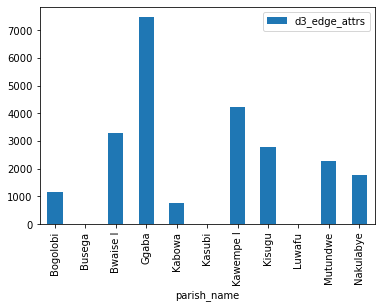

In [34]:
paired_cache_proj_gdf[['parish_name', 'd3_edge_attrs']].groupby(['parish_name']).mean().plot.bar()

<AxesSubplot:xlabel='parish_name'>

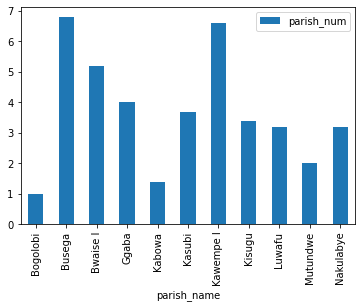

In [33]:
paired_cache_proj_gdf[['parish_name', 'parish_num']].groupby(['parish_name']).mean().plot.bar()